<a href="https://colab.research.google.com/github/yunialifah-ya/DeepLearningTasks/blob/main/TaskWeek2_Multilayer_Perceptrons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Yuni Alifah

NPM: 2306288950

Prodi: S2 Matematika

5.1. Multilayer Perceptrons

In this chapter, we will introduce your first truly deep network. The simplest deep networks are called multilayer perceptrons, and they consist of multiple layers of neurons each fully connected to those in the layer below (from which they receive input) and those above (which they, in turn, influence).

In [ ]:
!pip install d2l

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

In Section 4.1, we introduced softmax regression, implementing the algorithm from scratch (Section 4.4) and using high-level APIs (Section 4.5). This allowed us to train classifiers capable of recognizing 10 categories of clothing from low-resolution images. Along the way, we learned how to wrangle data, coerce our outputs into a valid probability distribution, apply an appropriate loss function, and minimize it with respect to our model’s parameters. Now that we have mastered these mechanics in the context of simple linear models, we can launch our exploration of deep neural networks, the comparatively rich class of models with which this book is primarily concerned.

4.4 Softmax Regression Implementation from Scratch

In [ ]:
#4.4. Softmax Regression Implementation from Scratch
import torch
from d2l import torch as d2l

In [ ]:
#4.4.1. The Softmax
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [ ]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1450, 0.1236, 0.2228, 0.2573, 0.2512],
         [0.1767, 0.2311, 0.1377, 0.1566, 0.2979]]),
 tensor([1., 1.]))

In [ ]:
#4.4.2. The Model
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [ ]:
#4.4.3. The Cross-Entropy Loss
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

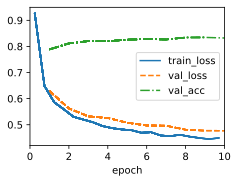

In [ ]:
#4.4.4. Training
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
#4.4.5. Prediction
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

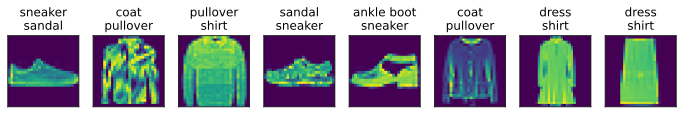

In [ ]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

4.5 Concise Implementation of Softmax Regression¶

In [ ]:
#4.5 Concise Implementation of Softmax Regression¶
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
#4.5.1. Defining the Model
class SoftmaxRegression(d2l.Classifier):
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

In [ ]:
#4.5.2. Softmax Revisited
@d2l.add_to_class(d2l.Classifier)
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

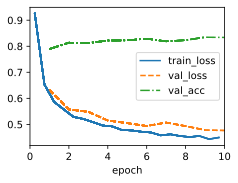

In [ ]:
#4.5.3. Training
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

4.5.4. Summary
High-level APIs are very convenient at hiding from their user potentially dangerous aspects, such as numerical stability. Moreover, they allow users to design models concisely with very few lines of code.

5.1.1. Hidden Layers

We described affine transformations in Section 3.1.1.1 as linear transformations with added bias.

In [ ]:
#3.1. Linear Regression
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [ ]:
#3.1.2. Vectorization for Speed
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [ ]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.12258 sec'

In [ ]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00032 sec'

In [ ]:
#3.1.3. The Normal Distribution and Squared Loss
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

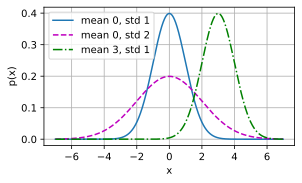

In [ ]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

To begin, recall the model architecture corresponding to our softmax regression example, illustrated in Fig. 4.1.1. This model maps inputs directly to outputs via a single affine transformation, followed by a softmax operation. If our labels truly were related to the input data by a simple affine transformation, then this approach would be sufficient. However, linearity (in affine transformations) is a strong assumption.

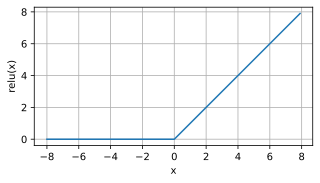

In [ ]:
#5.1.2.1. ReLU Function
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

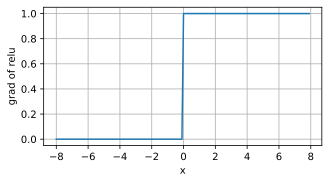

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

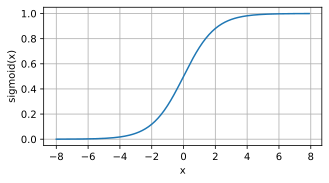

In [ ]:
#5.1.2.2. Sigmoid Function
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

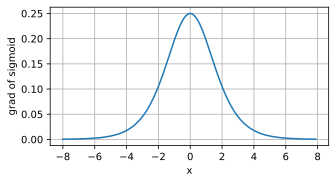

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

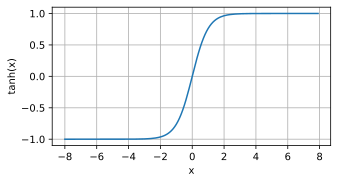

In [ ]:
#5.1.2.3. Tanh Function
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

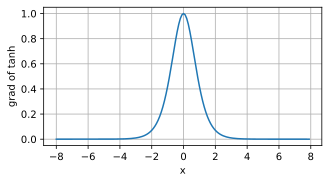

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

5.2. Implementation of Multilayer Perceptrons

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual difference is that we now concatenate multiple layers.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
#5.2.1. Implementation from Scratch
#5.2.1.1. Initializing Model Parameters
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [ ]:
#5.2.1.2. Model
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

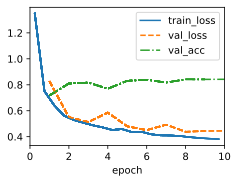

In [ ]:
#5.2.1.3. Training
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
#5.2.2. Concise Implementation
#5.2.2.1. Model
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

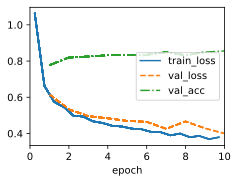

In [ ]:
#5.2.2.2. Training
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

5.3. Forward Propagation, Backward Propagation, and Computational Graphs.
Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer. Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order. When training deep learning models, forward propagation and backpropagation are interdependent, and training requires significantly more memory than prediction.

5.4. Numerical Stability and Initialization

In [ ]:
#5.4. Numerical Stability and Initialization
%matplotlib inline
import torch
from d2l import torch as d2l

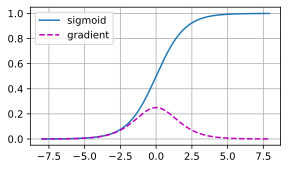

In [ ]:
#5.4.1. Vanishing and Exploding Gradients
#5.4.1.1. Vanishing Gradients
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [ ]:
#5.4.1.2. Exploding Gradients
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 1.8284,  0.9853,  1.0804,  2.0500],
        [-2.0109,  0.4923, -0.3195, -0.1653],
        [-0.2774,  0.2917, -0.8715,  1.1963],
        [-0.6371,  1.2961,  2.0939,  0.5804]])
after multiplying 100 matrices
 tensor([[ 2.1257e+24,  3.2915e+23, -2.4095e+23, -7.8308e+23],
        [ 1.0468e+24,  1.6209e+23, -1.1865e+23, -3.8562e+23],
        [ 2.1713e+24,  3.3622e+23, -2.4612e+23, -7.9990e+23],
        [ 7.9711e+23,  1.2343e+23, -9.0354e+22, -2.9365e+23]])


5.4.3. Summary
Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled. Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small. Random initialization is key to ensuring that symmetry is broken before optimization. Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs. ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.

5.5. Generalization in Deep Learning

5.5.5. Summary
Unlike classical linear models, which tend to have fewer parameters than examples, deep networks tend to be over-parametrized, and for most tasks are capable of perfectly fitting the training set. This interpolation regime challenges many hard fast-held intuitions. Functionally, neural networks look like parametric models. But thinking of them as nonparametric models can sometimes be a more reliable source of intuition. Because it is often the case that all deep networks under consideration are capable of fitting all of the training labels, nearly all gains must come by mitigating overfitting (closing the generalization gap). Paradoxically, the interventions that reduce the generalization gap sometimes appear to increase model complexity and at other times appear to decrease complexity. However, these methods seldom decrease complexity sufficiently for classical theory to explain the generalization of deep networks, and why certain choices lead to improved generalization remains for the most part a massive open question despite the concerted efforts of many brilliant researchers.

5.6. Dropout

In [ ]:
#Dropout
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
#5.6.1. Dropout in Practice
#5.6.2. Implementation from Scratch
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 20.,  0., 24.,  0.,  0., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:
#5.6.2.1. Defining the Model
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

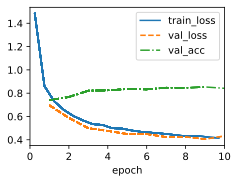

In [ ]:
#5.6.2.2. Training
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
#5.6.3. Concise Implementation
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

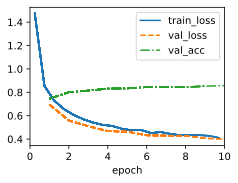

In [ ]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

5.6.4. Summary
Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool for avoiding overfitting. Often tools are used jointly. Note that dropout is used only during training: it replaces an activation h with a random variable with expected value h.

5.7. Predicting House Prices on Kaggle

In [ ]:
#5.7. Predicting House Prices on Kaggle
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
#5.7.1. Downloading Data
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [ ]:
#5.7.2. Kaggle
#5.7.3. Accessing and Reading the Dataset
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [ ]:
#5.7.4. Data Preprocessing
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

In [ ]:
#5.7.5. Error Measure
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [ ]:
#5.7.6. K-Fold Cross-Validation
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.18880439519882203


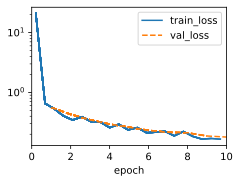

In [ ]:
#5.7.7. Model Selection
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [ ]:
#5.7.8. Submitting Predictions on Kaggle
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

5.7.9. Summary and Discussion
Real data often contains a mix of different data types and needs to be preprocessed. Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean. Furthermore, transforming categorical features into indicator features allows us to treat them like one-hot vectors. When we tend to care more about the relative error than about the absolute error, we can measure the discrepancy in the logarithm of the prediction. To select the model and adjust the hyperparameters, we can use K-fold cross-validation.